In [32]:
main_dir = "/Users/andrebeukers/Documents/fMRI/RVstudy/fromServ/Nov2_newFFA"

In [33]:
import os
from os.path import join as opj
from glob import glob
import mvpa2.suite as mvpa
import numpy as np
import pandas as pd
import plots_RV

In [34]:
task = 'pain'
roi = 'lFFA'
meanCSp = 0

sample file: sub-007_TASK-pain_ROI-lFFA_GLMresults-nifti.nii.gz

# Dirs

In [35]:
GLMresults_dir = opj(main_dir, '%s_GLM' % task)
RSAresults_dir = opj(main_dir, '%s_RSA' % task)

if not os.path.isdir(RSAresults_dir):
    os.mkdir(RSAresults_dir)

In [36]:
ratings = pd.read_csv(opj(main_dir,"mana_rate.csv"))


# Sample Attributes

In [37]:
t = lambda x,y: np.tile(x,y)
tn = lambda x: np.arange(x)+1

In [38]:
roi_list = t(roi, 51)
task_list = t(task, 51)

# assume order of stim_times_IM in GLM file unchanged
trialtype_list = np.concatenate(
    ( t('tp',14), t('tm',7), t('cp',12), t('cm',6), t('us',12) ))

trialnum_list = [1,1,2,2,3,3,4,4,5,5,6,6,7,7]
trialnum_list.extend(np.arange(7) + 1)
trialnum_list.extend(range(30))

In [39]:
# initialize (populate in loop)
trial_list = np.chararray(len(trialtype_list), itemsize = 15)
stim_list = np.chararray(len(trialtype_list), itemsize = 15)
CS_list = np.chararray(len(trialtype_list), itemsize = 15)
CSone_idx = 0; CStwo_idx = 0;

In [40]:
for i in range(len(trial_list)):
    if (i < 14) & (i%2 == 0):
        trial_list[i] = 'CS+1 %.2i' % trialnum_list[i]
        stim_list[i] = 'CS+1'
        CS_list[i] = 'CS+'
    elif (i < 14) & (i%2 == 1):
        CStwo_idx += 1
        trial_list[i] = 'CS+2 %.2i' % trialnum_list[i]
        stim_list[i] = 'CS+2'
        CS_list[i] = 'CS+'
    elif i < 14+7: 
        trial_list[i] = 'CS- %.2i' % trialnum_list[i]
        stim_list[i] = 'CS-'
        CS_list[i] = 'CS-'
    else:
        break

# RSA loop

In [41]:
# prepare DSM 
dsm_measure = mvpa.measures.rsa.PDist(square=True)

# loop containers
ds_list = []; dsm_list = []

# loop beta volumes (GLM results), load fmri_dataset
GLMresults_list = glob(opj(GLMresults_dir,"*%s*nifti*" % roi))

In [42]:
for fpath in GLMresults_list:

    # file fpath and subject number
    sub_num = fpath.split('/')[-1].split('_')[0].split('-')[-1]
    print "RSAing subj: " + sub_num

    # conditioner score 
    condit = ratings[ratings['Subject'] == int(sub_num)]['Conditioner']
    
    # load beta volumes of single subject
    sub_ds = mvpa.fmri_dataset(fpath)
    assert sub_ds.shape == (51, 141120)
    
    # sample attributes
    sub_ds.sa['sub_num'] = \
        (np.ones(sub_ds.nsamples)*int(sub_num)).astype(int)
    sub_ds.sa['trialtype'] = trialtype_list
    sub_ds.sa['trialnum'] = trialnum_list
    sub_ds.sa['roi'] = roi_list
    sub_ds.sa['task'] = task_list
    sub_ds.sa['stim'] = stim_list
    sub_ds.sa['trial'] = trial_list
    sub_ds.sa['condit'] = np.tile(condit,51)
    sub_ds.sa['CS'] = CS_list

    # get target trials only
    idx_tp = (sub_ds.sa.trialtype == 'tp')
    idx_tm = (sub_ds.sa.trialtype == 'tm')
    sub_ds = sub_ds[idx_tp | idx_tm]
    assert sub_ds.shape == (21, 141120)
    # assert False
    
    # grouping CS+1 CS+2 CS-
    t = range(0,13,2)
    t.extend(range(1,14,2))
    t.extend(range(14,21))
    temp = []
    for i in t:
        temp.extend(sub_ds[i,:])
    sub_ds = mvpa.vstack(temp,a=0)
    
    # avg(CS+1,CS+2) beta volumes
    if meanCSp:
        ds_plus = CSmean(sub_ds[sub_ds.sa.CS == 'CS+'])
        ds_minus = sub_ds[sub_ds.sa.stim == 'CS-']
        sub_ds = mvpa.vstack([ds_plus,ds_minus])
        sub_ds.sa.stim[sub_ds.sa.stim == 'CS+1+CS+2'] = 'CS+'

    # RDM -> RSM
    sub_dsm = dsm_measure(sub_ds)
    sub_dsm.samples = sub_dsm.samples * (-1) + 1
    sub_dsm.fa['trial'] = sub_dsm.sa.trial[:]
    
    # fisher transform
    sub_dsm.samples = np.arctanh(sub_dsm.samples)

    # list of DSMs and DSs of each subject
    if np.unique(sub_ds.sa.sub_num) not in [4, 6, 19, 20, 335]:
        dsm_list.append(sub_dsm)
        ds_list.append(sub_ds)


RSAing subj: 007


/Users/andrebeukers/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: divide by zero encountered in arctanh


RSAing subj: 009
RSAing subj: 012
RSAing subj: 014
RSAing subj: 015
RSAing subj: 016
RSAing subj: 017
RSAing subj: 018
RSAing subj: 021
RSAing subj: 024
RSAing subj: 025
RSAing subj: 026
RSAing subj: 027
RSAing subj: 028
RSAing subj: 029
RSAing subj: 030
RSAing subj: 033
RSAing subj: 359


## Group analyses

In [43]:
full_stack = mvpa.vstack(dsm_list, a=0) 
mgs = mvpa.mean_group_sample(["trial"], order='occurrence')

# conditioners vs non
condit_idx = full_stack.sa.condit == 1
noncondit_idx = full_stack.sa.condit == 0

condit_stack = full_stack[condit_idx]
noncondit_stack = full_stack[noncondit_idx]

# dsms
dsm_c = mgs(condit_stack)
dsm_n = mgs(noncondit_stack)
dsm_group = mgs(full_stack)

# ?
# dsm_c.samples = np.tanh(dsm_c.samples)
# dsm_n.samples = np.tanh(dsm_n.samples)


# Plots

In [44]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [45]:
def plot_dsm(dsm, title = 'Corr distance'):
    # figure
    fig = plt.figure(figsize=(10,8))
    plt.imshow(dsm, interpolation='nearest')
    plt.xticks(np.arange(len(dsm))+.5, dsm.sa.trial, rotation=-45)
    plt.yticks(range(len(dsm)), dsm.sa.trial)
    plt.title(title)
    plt.clim(-1, 1)
    plt.colorbar()

    # black square
    ax = fig.add_subplot(111)
    for xy in [-.5,6.5,13.5]:
        ax.add_patch(mpl.patches.Rectangle((xy,xy),
            7,7,linewidth=3,color='black',fill=False))

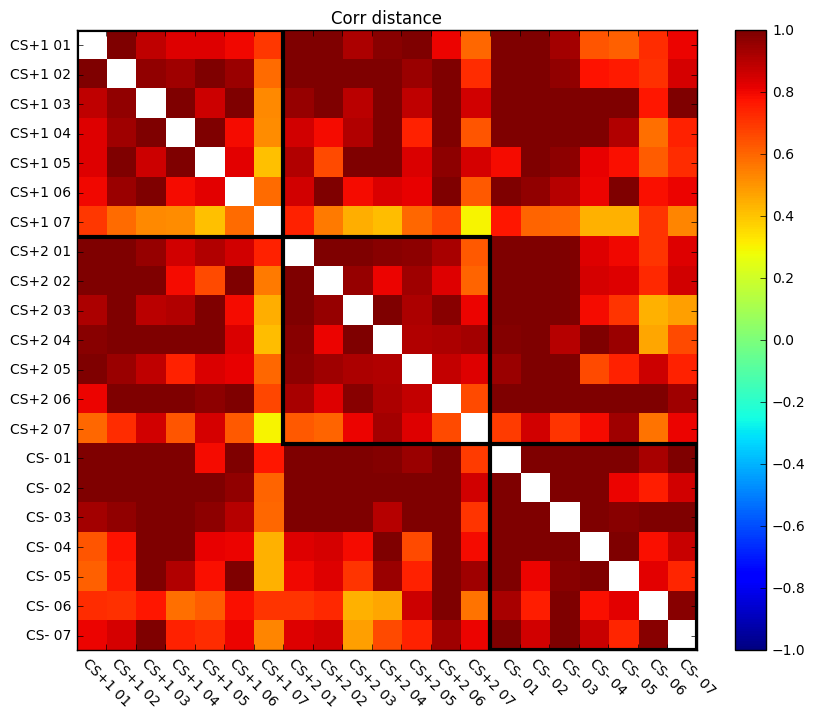

In [46]:
plot_dsm(dsm_group)

## Line plots


In [47]:
# gets diagonal entries
def get_dmchange(dsm, stim):

    # reduced matrix with sitm only 
    idx_stim = dsm.sa.stim == stim
    stim_dsm = dsm[idx_stim,idx_stim]

    # index for off diagonal
    row_idx, col_idx = np.diag_indices(len(stim_dsm)-1)

    # off diagonal
    dm_change = stim_dsm.samples[[row_idx+1,col_idx]]
    print dm_change

    return dm_change

# label x-axis
def labelx():
    xlab = ["%i - %i" % (i, i+1) for i in range(8)[1:]]
    plt.xticks(np.arange(6), xlab, rotation = -45)

### CS+ vs CS-

In [48]:
def dmchange_fig(dsm, stim_list=['CS+1','CS+2','CS-']):

    # plot dissimilarity change
    for stim in stim_list:
        dmchange = get_dmchange(dsm, stim)
        plt.plot(dmchange, label = stim)
        plt.legend()

    labelx()

[ 0.91247771  1.1068322   0.79180275  0.87188045  1.17987541  0.73539141]
[ 1.08696124  0.62709923  0.4876603   0.93605837  0.97902849  0.98781549]
[ 1.28368618  1.04797845  0.91732675  1.26679111  1.09859932  1.27993275]


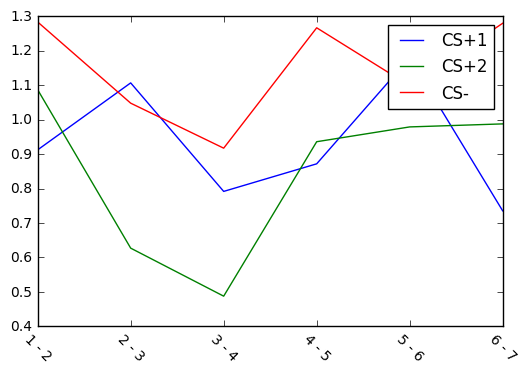

In [49]:
dmchange_fig(dsm_c)

### CS + conditioners vs CS+ non-conditioners

In [54]:
# CS+ conditioners vs CS+ non-conditioners
def dmchange_fig2(dsm_c,dsm_n,stim_list=['CS+','CS-']):

    for stim in stim_list:

        # plot dissimilarity change
        dmchange_c = get_dmchange(dsm_c, stim)
        dmchange_n = get_dmchange(dsm_n, stim)

        plt.plot(dmchange_c, label="C %s" % stim)
        plt.plot(dmchange_n, label="N %s" % stim)
        plt.legend()

        labelx()
#         figsave(dsm_c, fname="%s_condVSnon" % stim)

[]
[]
[ 1.28368618  1.04797845  0.91732675  1.26679111  1.09859932  1.27993275]
[ 1.28808356  1.27314492  1.34749971  0.97521503  0.65126734  0.78473779]


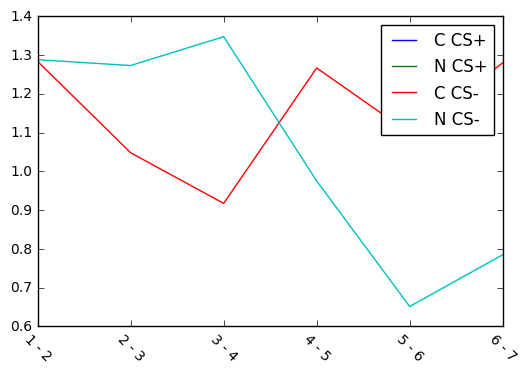

In [55]:
dmchange_fig2(dsm_c,dsm_n)